<a href="https://colab.research.google.com/github/jaeseonim/my-ai-journey/blob/main/karpathy-ai-study/02_makemore_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [ ]:
# /content/drive/MyDrive/karpathy/names.txt

words = open('/content/drive/MyDrive/karpathy/names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [ ]:
len(words)

32033

In [ ]:
min(len(w) for w in words)

2

In [ ]:
max(len(w) for w in words)

15

bigram으로 시작. bigram은 오로지 다음 문자만 예측하지만 langauge model 시작하기에 좋다

pytorch의 'broadcasting semantics' 문서를 잘 읽어봐라.

[링크](https://docs.pytorch.org/docs/stable/notes/broadcasting.html)

keepdim = True vs. False

강의에서 sampling이라는 단어를 많이 쓴다!

모델이 이름을 하나 지어내는 과정은 다음과 같습니다:
- 시작(Seed): 항상 특수 문자인 마침표(.)에서 시작합니다.
- 확률 확인: 현재 문자(처음엔 .)에 해당하는 행(Row)을 확률 행렬 $P$에서 찾습니다.
- 선택(Sampling): 그 행에 적힌 확률들에 따라 torch.multinomial을 사용해 다음 글자를 '무작위'로 하나 뽑습니다.
- 반복: 새로 뽑힌 글자를 다음 입력으로 삼아 2~3단계를 계속 반복하다가, 다시 마침표(.)가 나오면 멈춥니다.


왜 '생성(Generating)' 대신 '샘플링'이라고 부를까요?

우리는 확률 분포라는 전체 집단(Population)에서 특정한 표본(Sample) 하나를 끄집어내는 것이기 때문에 샘플링이라는 표현을 씁니다.

예를 들어, 'A' 다음에 'B'가 올 확률이 70%, 'C'가 올 확률이 30%라고 모델이 학습했다면, 'B'와 'C'가 섞인 거대한 확률 주머니가 있는 셈입니다.

우리가 주사위를 던져서 실제로 'B'라는 글자 하나를 확정 짓는 행위가 바로 이 주머니에서 표본 하나를 추출(Sampling) 하는 것이죠.

만약 가장 높은 확률을 가진 글자만 무조건 뽑는다면(이건 Argmax라고 합니다), 모델은 매번 똑같은 이름만 생성하게 됩니다. 하지만 샘플링을 하면 확률이 낮은 글자도 가끔 뽑히기 때문에, 모델이 매번 조금씩 다른 이름을 생성하는 '창의성'을 보여줄 수 있게 됩니다.

안드레의 팁: 강의 후반부에 우리가 만든 바이그램 모델로 샘플링을 해봤을 때, 꽤 그럴듯한 이름(예: mor)도 나오지만 말도 안 되는 이름(예: h)도 나왔던 것 기억하시나요? 그게 바로 모델이 가진 통계적 지능의 한계이자 샘플링이 보여주는 날 것 그대로의 결과물입니다.

모델의 quality를 계산해보자.

모델을 다 만들고 나면, 이 녀석이 얼마나 똑똑한지(혹은 멍청한지)를 하나의 숫자로 요약해서 보고 싶어지죠. 그래서 우리는 '가능도(Likelihood)'라는 개념을 가져옵니다.



likelihood: 모든 확률값을 곱해 -> `a * b * c`

log likelihood: 각 확률값에 로그를 씌운 다음에 더해 -> log(`a * b * c`)

근데 이렇게 하면 1에 가까울수록 0이고, 0에 가까울수록 음수 무한대로 간다.

손실함수는 이 의미와 반대이므로 log likelihood에 음수를 붙여준다. 이를 'negative log likelihood'라고 한다.

여기서 개수(3)으로 나누어 정규화도 해준다.

likelihood에 대한 개념부터 짚고 넘어가자.

likelihood는 우리 모델이 실제 데이터셋을 얼마나 잘 설명하는가에 대한 개념이다. <=> Likelihood의 원래 의미는 **"내가 세운 모델(파라미터 $\theta$)이 지금 내 눈앞에 있는 실제 데이터($D$)를 얼마나 잘 설명하는가?"**에 대한 척도입니다.

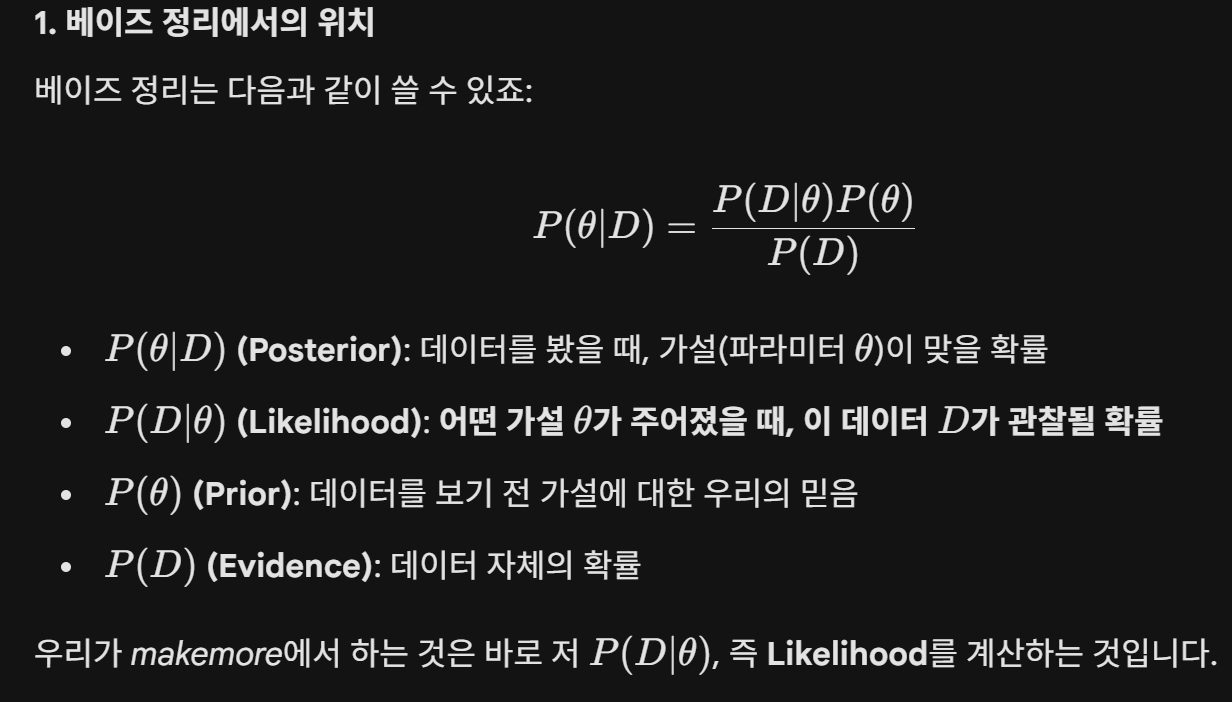

maximum likelihood estimation ([위키피디아](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation))

https://www.youtube.com/watch?v=vzNRLY_hLlM&list=PLRUS1nW-CfnfWT3ORO0ZmjgUQaCkRhEZM&index=16 -> 이 강의도 좋다

훈련의 목표는 손실함수(negative log likelihood)의 값을 최소화하는 매개변수 값을 찾는 것이다!

bigram 표를 통해서 확률분포를 구한건데 이개 곧 매개변수 값(모델)이라고 할 수 있지 않을까? -> 매개변수는 이미 정한거고, 여기서 데이터값이 나올 확률이 likelihood라고 일단 1차적으로 이해하자

지금까지는 단순히 count를 통해 구했다면, 이제는 다른 방법을 사용해보고자 한다.

In [ ]:
# 1. 모든 단어를 합쳐서 고유한 알파벳 리스트를 만들고 정렬합니다.
chars = sorted(list(set(''.join(words))))

# 2. 글자 -> 숫자로 매핑하는 사전을 만듭니다. (a=1, b=2, ..., z=26)
stoi = {s:i+1 for i,s in enumerate(chars)}

# 3. 특수 문자 '.'를 0번에 할당합니다.
stoi['.'] = 0

# 4. 반대로 숫자 -> 글자로 바꿔주는 사전도 만들어두면 나중에 편리합니다.
itos = {i:s for s,i in stoi.items()}

In [ ]:
import torch

In [ ]:
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# 정수를 그대로 input과 output으로 쓰는 건 적절치 않음
# 우리는 각 문자를 정수로 라벨링했는데, 1과 5에 대해서 5배 관계가 아니기 때문. 보통 키 같은 건 인정이지만 여기선 ㄴㄴ
# 그리고 뉴럴넷은 y = wx + b 형태로 계산하는데, x y 가 하나의 스칼라 값이라면 모든 x는 동일한 가중치 w를 공유하게 됨
# 하지만 원핫인코딩하면 각각의 X는 자신만의 독립적인 가중치를 갖게 된다
# 딥러닝에서는 x @ W를 한다. 그러면 x가 c = [0,0,1,0,...]라면 c를 담당하는 W의 가중치는 3번째 행에 있다.

수학적 관점 ($Wx$) vs 공학적 관점 ($xW$)

- 수학 교과서 ($Wx$): 보통 데이터 하나($x$)를 열 벡터(Column Vector)로 처리합니다. 그래서 가중치 행렬 $W$가 앞에 와야 행렬 곱셈의 차원이 맞습니다.
- 딥러닝 코드 ($xW$): 데이터를 배치(Batch) 단위로 처리하기 때문입니다. 딥러닝에서 데이터는 보통 행(Row) 방향으로 쌓입니다. 즉, $x$의 첫 번째 차원이 데이터의 개수(배치 크기)가 됩니다.

In [ ]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # 정수를 원핫 벡터로 변환
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc.shape

torch.Size([5, 27])

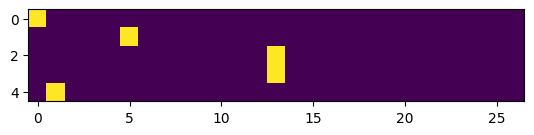

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(xenc)

In [ ]:
# float로 바꿔주는 이유는 다양한 값을 가지게 하기 위해서!
xenc.dtype

torch.float32

In [ ]:
W = torch.randn((27,1))
# 행렬 곱셈은 내적(dot product)의 병렬 연산이다. 한번에 계산해줌. 내적은 두 벡터가 얼마나 닮았냐를 나타냄.
# 이렇게 행렬 곱 통해 얻은 내적 값들의 뭉치를 logits라고 한다.
# 5개의 입력값을 동일한 뉴런(W)에 넣어버림 -> 각각의 X는 독립적인 값을 갖게 된다
# micrograd에서는 w * x + b 로 했지? 이때는 w와 x가 둘 다 벡터였어. 그래서 그냥 내적하면 되었지.
# 근데 여기서는 5개 한꺼번에 하니깐 행렬 곱셈을 하는 거야!
# 행렬 곱셈은 선형변환해서 차원을 바꿔주는 거라는 직관이 여기서 나오는구만
# 심지어 전강에서는 각각의 layer에 있는 노드들에 대해 각각 가중치 벡터를 만들었는데 이렇게 행렬로 해버리면 하나의 W 행렬로 표현 가능하려나?
xenc @ W

tensor([[-0.0444],
        [ 1.5854],
        [ 0.7351],
        [ 0.7351],
        [ 0.0973]])

In [ ]:
# (27,1) 대신 (27,27)
W = torch.randn((27,27))
xenc @ W

tensor([[-0.1329,  0.8217,  0.2164, -0.9963,  0.0396,  0.3632, -0.2334,  0.1250,
         -1.5220, -0.0287,  0.1146,  0.4939, -0.7779,  1.8853,  0.1540,  0.8798,
          1.2367,  0.4043,  1.1369, -1.2885, -0.8000,  0.3206, -1.5257,  1.8808,
         -1.5034, -1.6851,  1.4643],
        [-1.1973, -0.4157, -0.1494,  0.3546, -0.6276,  0.9548, -0.4738,  0.7773,
         -0.1299, -0.4092,  0.0696,  0.1672, -0.1216,  0.8277, -0.5758,  0.6263,
          1.4091,  0.7412, -1.6012,  0.2703,  0.8326,  1.2989,  0.2061,  0.1503,
          0.4735,  0.4823, -1.7300],
        [ 1.5758,  0.1233,  0.4914, -1.0339, -1.0920,  0.7410,  0.4523, -0.6079,
         -1.7882,  0.9084, -0.7426, -0.0167, -1.0249, -0.0181,  0.4706, -0.7357,
         -0.7003,  0.5214, -0.6449,  0.7520, -0.7568,  1.2156,  1.1613,  0.1416,
         -0.5154,  0.3088,  1.0296],
        [ 1.5758,  0.1233,  0.4914, -1.0339, -1.0920,  0.7410,  0.4523, -0.6079,
         -1.7882,  0.9084, -0.7426, -0.0167, -1.0249, -0.0181,  0.4706, -0.7357

In [ ]:
# 위의 각각의 값은 정규분포 따르는 음수 양수 값을 모두 가짐
# 우리는 이를 확률로서 해석하고 싶기 때문에 일단 양수로 만들어주기 위해서 exp()를 씌운다.
# 그러면 음수값은 1보다 작은 값이 되고, 양수값은 1보다 큰 값이 된다
# exp()를 씌우면 아까 bigram table에서 봤었던 count로 볼 수 있지. 둘 다 양수값.
(xenc @ W).exp()

tensor([[ 0.8756,  2.2743,  1.2415,  0.3693,  1.0404,  1.4380,  0.7918,  1.1331,
          0.2183,  0.9717,  1.1214,  1.6386,  0.4593,  6.5883,  1.1665,  2.4104,
          3.4441,  1.4983,  3.1170,  0.2757,  0.4493,  1.3779,  0.2175,  6.5587,
          0.2224,  0.1854,  4.3245],
        [ 0.3020,  0.6599,  0.8612,  1.4256,  0.5338,  2.5983,  0.6226,  2.1756,
          0.8782,  0.6642,  1.0721,  1.1820,  0.8855,  2.2880,  0.5622,  1.8706,
          4.0921,  2.0984,  0.2017,  1.3103,  2.2992,  3.6653,  1.2289,  1.1622,
          1.6057,  1.6198,  0.1773],
        [ 4.8345,  1.1312,  1.6346,  0.3556,  0.3355,  2.0980,  1.5719,  0.5445,
          0.1673,  2.4803,  0.4759,  0.9834,  0.3588,  0.9820,  1.6010,  0.4791,
          0.4964,  1.6845,  0.5247,  2.1213,  0.4692,  3.3723,  3.1941,  1.1521,
          0.5973,  1.3618,  2.7999],
        [ 4.8345,  1.1312,  1.6346,  0.3556,  0.3355,  2.0980,  1.5719,  0.5445,
          0.1673,  2.4803,  0.4759,  0.9834,  0.3588,  0.9820,  1.6010,  0.4791

In [ ]:
logits = xenc @ W # log-counts
counts = logits.exp() # bigram의 table과 동일
probs = counts / counts.sum(1, keepdims = True) # 정규화하는데 이게 softmax 함수네?
# 확률분포를 얻은 거임
probs

tensor([[0.0193, 0.0501, 0.0273, 0.0081, 0.0229, 0.0317, 0.0174, 0.0250, 0.0048,
         0.0214, 0.0247, 0.0361, 0.0101, 0.1451, 0.0257, 0.0531, 0.0758, 0.0330,
         0.0686, 0.0061, 0.0099, 0.0303, 0.0048, 0.1444, 0.0049, 0.0041, 0.0952],
        [0.0079, 0.0173, 0.0226, 0.0375, 0.0140, 0.0683, 0.0164, 0.0572, 0.0231,
         0.0175, 0.0282, 0.0311, 0.0233, 0.0601, 0.0148, 0.0492, 0.1076, 0.0552,
         0.0053, 0.0344, 0.0604, 0.0963, 0.0323, 0.0305, 0.0422, 0.0426, 0.0047],
        [0.1279, 0.0299, 0.0432, 0.0094, 0.0089, 0.0555, 0.0416, 0.0144, 0.0044,
         0.0656, 0.0126, 0.0260, 0.0095, 0.0260, 0.0423, 0.0127, 0.0131, 0.0446,
         0.0139, 0.0561, 0.0124, 0.0892, 0.0845, 0.0305, 0.0158, 0.0360, 0.0741],
        [0.1279, 0.0299, 0.0432, 0.0094, 0.0089, 0.0555, 0.0416, 0.0144, 0.0044,
         0.0656, 0.0126, 0.0260, 0.0095, 0.0260, 0.0423, 0.0127, 0.0131, 0.0446,
         0.0139, 0.0561, 0.0124, 0.0892, 0.0845, 0.0305, 0.0158, 0.0360, 0.0741],
        [0.0346, 0.2011,

In [ ]:
# summary

In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# gradient 구하기 위해 requires_grad = True 설정
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# forward pass
# 아직 MLP가 아니라 SINGLE LINEAR LAYER 다.
xenc = F.one_hot(xs, num_classes = 27).float() # inputs to the network: one-hot encoding
logits = xenc @ W
# 아래 두 줄을 softmax라고 함
counts = logits.exp()
probs = counts / counts.sum(1, keepdim = True)
# 손실함수: 아까 살펴봤던 'average' negative log likelihood
# 손실함수가 0에 가깝다? -> likelihood를 곱한 값들이 1에 수렴한다...애초에 정답지가 확률값인 1이라고 이해하면 되네? 오...
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
# loop 돌릴수록 점점 줄어든다
print(loss)

tensor(3.6892, grad_fn=<NegBackward0>)


In [ ]:
# backward pass
W.grad = None # gradient를 0으로 설정
# micrograd 때 했던 것처럼 pytorch에 backward() 메소드가 내장되어 있어
loss.backward()

In [ ]:
# update
W.data += -0.1 * W.grad

In [ ]:
# 다시 짜보자 이제

In [ ]:
# create the dataset (모든 단어 이번엔!)
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of elements: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator = g, requires_grad=True)

number of elements:  228146


In [ ]:
# gradient descent
for k in range(100):

  # forward pass

  xenc = F.one_hot(xs, num_classes = 27).float() # inputs to the network: one-hot encoding
  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdim = True)
  # 5 대신 num
  loss = -probs[torch.arange(num), ys].log().mean()
  print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  # update
  W.data += -50 * W.grad

2.4726526737213135
2.4724340438842773
2.4722204208374023
2.472010850906372
2.471806049346924
2.4716053009033203
2.471409320831299
2.4712166786193848
2.4710280895233154
2.4708433151245117
2.4706623554229736
2.4704854488372803
2.4703118801116943
2.4701414108276367
2.4699742794036865
2.4698104858398438
2.46964955329895
2.469492197036743
2.4693377017974854
2.4691860675811768
2.469036817550659
2.468891143798828
2.468747615814209
2.46860671043396
2.468468427658081
2.468332529067993
2.4681990146636963
2.4680681228637695
2.4679393768310547
2.4678127765655518
2.467688798904419
2.4675662517547607
2.4674463272094727
2.4673283100128174
2.467212438583374
2.467097759246826
2.4669857025146484
2.4668753147125244
2.466766834259033
2.4666595458984375
2.4665544033050537
2.466451406478882
2.4663491249084473
2.4662492275238037
2.4661502838134766
2.4660532474517822
2.4659576416015625
2.4658634662628174
2.4657704830169678
2.465679407119751
2.4655895233154297
2.465500593185425
2.4654135704040527
2.46532726287

In [ ]:
# bigram 했을 때도 2.47의 loss 값이 나왔는데 위 훈련결과 비슷한 값이 나오는 걸 볼 수 있어

In [ ]:
# regularization

우리는 손실 함수(Loss)를 줄이기 위해 가중치 $W$를 계속 업데이트합니다. 그런데 모델이 특정 데이터에 너무 집착하면 어떻게 될까요?

특정 바이그램 확률을 100%로 만들기 위해 $W$의 특정 값을 무한히 크게 키우려고 할 것입니다.이렇게 $W$가 너무 커지면 모델은 훈련 데이터는 완벽하게 맞히지만, 처음 보는 데이터에는 아주 멍청하게 반응하는 과적합(Overfitting) 상태에 빠집니다.정규화는 손실 함수에 가중치의 크기를 더해버리는 것입니다.$$Loss = \text{Negative Log Likelihood} + \lambda \times W^2$$이제 모델은 손실을 줄이려면 (1) 정답을 잘 맞히면서도 동시에 (2) 가중치($W$)를 가급적 작게 유지해야 하는 이중 과제를 안게 됩니다.

 '+1 Smoothing'과의 놀라운 연결 고리

 강의 초반, 우리가 빈도표(Matrix $N$)에 가짜로 1을 더해줬던 것 기억하시나요? (P = (N+1) / (N+1).sum())그때 우리는 **"한 번도 안 나온 바이그램도 아주 작은 확률이라도 갖게 하자"**고 했습니다. 그래야 손실이 무한대가 안 되니까요.

 신경망에서 정규화는 정확히 똑같은 일을 합니다.
 - 가중치($W$)가 0에 가까울수록: exp(W)는 1에 가까워지고, 소프트맥스 결과는 모든 글자에 **고른 확률(Uniform distribution)**을 줍니다.
 - **즉, 정규화 세기를 높이는 것($\lambda$를 키우는 것)**은 빈도표 방식에서 가짜 숫자(counts)를 더 많이 더해주는 것과 수학적으로 동일한 효과를 냅니다. 모델을 더 '평평하게(Smooth)' 만드는 것이죠.

"정규화는 모델이 훈련 데이터의 아주 사소한 노이즈까지 다 외워버리는 것을 방지하기 위해, 가중치를 0이라는 부드러운 상태로 끌어당기는 '고무줄' 같은 역할을 합니다."

In [ ]:
# loss = loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
# 확률값 100% 만들기 위해선...지수함수에 들어갈 로짓값을 키워야 함 -> W maximize!

In [ ]:
# finally, sampling을 해보자!

g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    # sampling하는데 이때 가장 높은 확률을 내뱉는게 아니라, 확률값에 맞춰서!
    ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
    out.append(itos[ix])
    if ix == 0:
      break

  print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


단순 선형 모델로 경사하강법 학습을 진행했고, 이제 이게 MLP에서 Transformer까지 복잡해지는 것 뿐.

# Part 2

[지난 시간 복습 및 인트로]

- bigram의 한계점
  - 뒤의 글자를 보고 시퀀스 예측하는 거는 '문맥'을 이해하는 데 턱없이 부족하다.
  - 아직까지는 'character'(각 단어의 문자 그 자체)만 보는 상태.
  - 결과: 모델이 내뱉는 이름들이 그럴싸하긴 하지만, 여전히 좀 '멍청한' 느낌이 강했음.
- 벤지오(Bengio et al. 2003) 논문의 등장
  - 링크: https://jmlr.org/papers/volume3/tmp/bengio03a.pdf
  - 아이디어: "글자 하나만 보지 말고, 여러 개의 글자(문맥)를 한꺼번에 보자!"
  - 확장성: 예를 들어, 앞의 글자 3개를 보고 그다음 4번째 글자를 예측하는 식입니다. 문맥이 길어질수록 모델은 훨씬 똑똑해집니다.
- MLP 모델의 새로운 구조 (핵심 설계도)
  - 임베딩(Embedding): 27개의 글자를 아주 작은 차원(예: 2차원 공간)의 점(Vector)으로 표현합니다. 이제 글자는 단순한 인덱스가 아니라 공간상의 '좌표'가 됩니다.
  - 문맥 합치기(Concatenation): 만약 앞의 3글자를 본다면, 이 3글자의 임베딩 벡터를 하나로 길게 이어 붙입니다.
  - 은닉층(Hidden Layer): 합쳐진 벡터를 은닉층에 통과시킵니다. 여기서 tanh 같은 비선형 함수를 써서 모델에 '지능'을 부여합니다.
  - 출력층(Output Layer): 마지막으로 다시 27개의 숫자로 변환하고, 우리가 배운 소프트맥스(Softmax)를 취해 다음 글자의 확률을 구합니다.

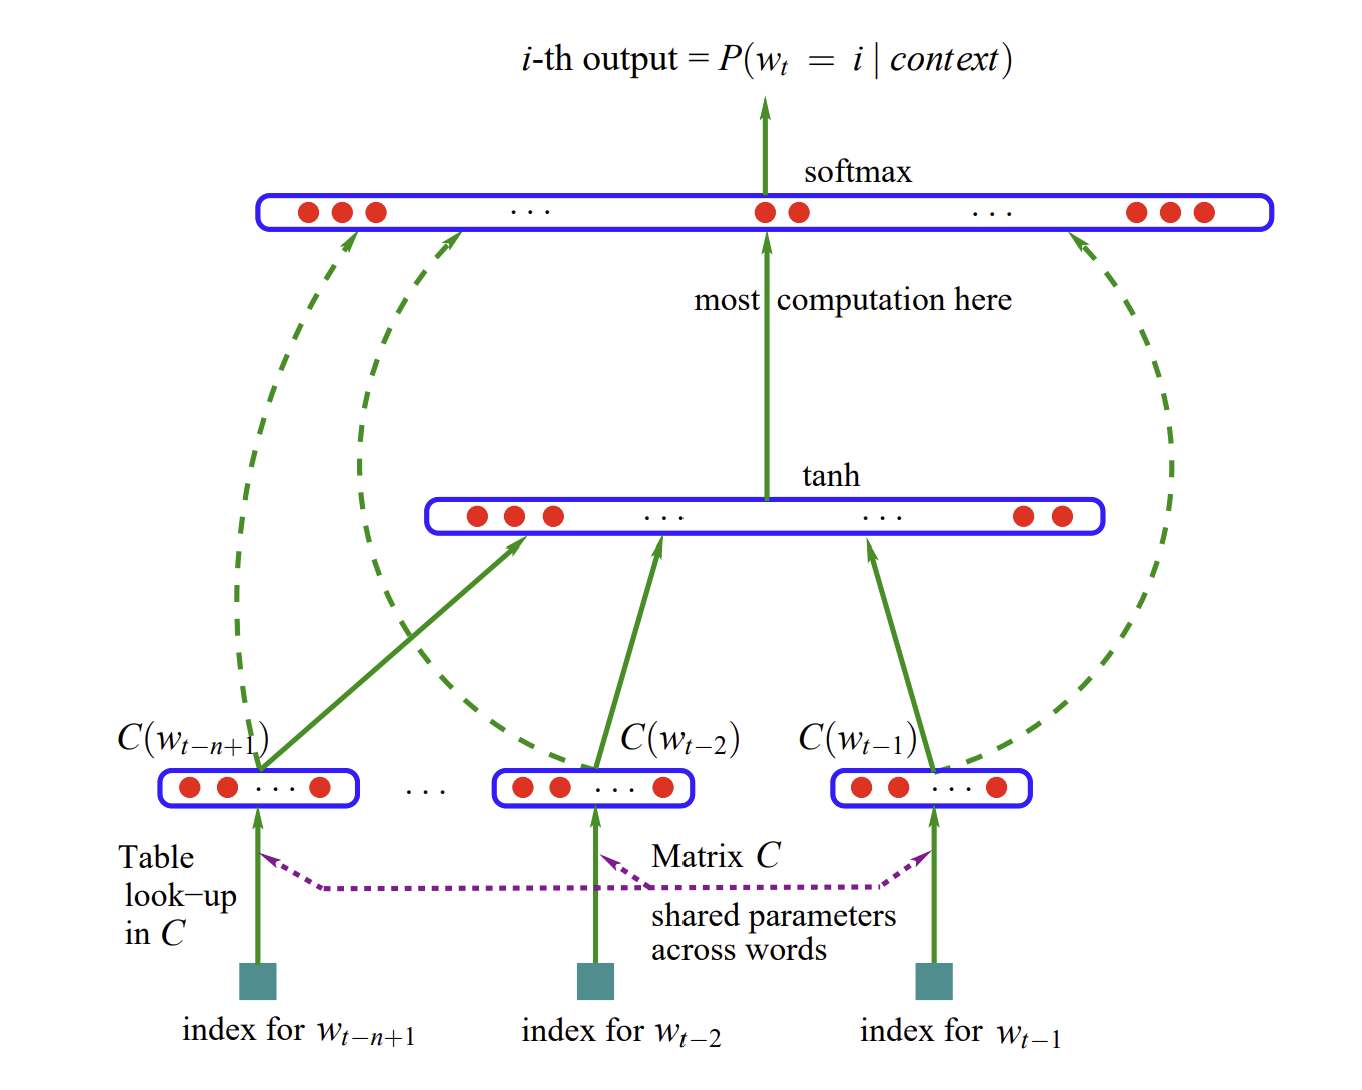

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('/content/drive/MyDrive/karpathy/names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
len(words)

32033

In [7]:
# 각 문자열을 정수로 일대일 대응 시키기

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# 데이터셋을 만들자

block_size = 3 # 논문의 숫자와 동일
X, Y = [], []
for w in words[:5]:

  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [12]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [13]:
# 논문에서는 17000개 '단어'를 30차원으로 축소해서 임베딩을 함
# 근데 우리의 실습에서는 27개의 문자열을 다루기 때문에 일단 간단하게 2차원으로 축소해보자

C = torch.randn((27,2))

In [58]:
C

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]])

In [15]:
C[5]

tensor([ 0.2577, -0.8432])

In [16]:
# X를 임베딩
C[X]

tensor([[[ 0.0543, -0.8232],
         [ 0.0543, -0.8232],
         [ 0.0543, -0.8232]],

        [[ 0.0543, -0.8232],
         [ 0.0543, -0.8232],
         [ 0.2577, -0.8432]],

        [[ 0.0543, -0.8232],
         [ 0.2577, -0.8432],
         [ 1.3544,  0.4264]],

        [[ 0.2577, -0.8432],
         [ 1.3544,  0.4264],
         [ 1.3544,  0.4264]],

        [[ 1.3544,  0.4264],
         [ 1.3544,  0.4264],
         [-0.6683, -0.1645]],

        [[ 0.0543, -0.8232],
         [ 0.0543, -0.8232],
         [ 0.0543, -0.8232]],

        [[ 0.0543, -0.8232],
         [ 0.0543, -0.8232],
         [-1.1927,  0.1847]],

        [[ 0.0543, -0.8232],
         [-1.1927,  0.1847],
         [ 0.4870,  0.3607]],

        [[-1.1927,  0.1847],
         [ 0.4870,  0.3607],
         [ 0.2235, -0.1756]],

        [[ 0.4870,  0.3607],
         [ 0.2235, -0.1756],
         [ 0.4000, -0.3813]],

        [[ 0.2235, -0.1756],
         [ 0.4000, -0.3813],
         [ 0.2235, -0.1756]],

        [[ 0.4000, -0

In [17]:
C[X].shape

torch.Size([32, 3, 2])

In [21]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [31]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))
# emb @ W1 + b1 -> 이렇게 하면 emb.shape 크기 때문에 계산이 안 된다. 항상 shape를 보자.

In [23]:
emb[:, 0, :].shape

torch.Size([32, 2])

In [25]:
# torch.cat 사용
# 32 x 3 x 2 -> 32 x 6
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [28]:
# torch.unbind로 쓰면 블록 수 몇 개이던 상관없이 일반화 가능
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [34]:
# view는 굉장한 물건
# torch의 storage와 메모리에 대한 직관적 이해를 가지자
emb.view(32, 6).shape

torch.Size([32, 6])

In [35]:
# 다시 돌아와서
h = torch.tanh(emb.view(32, 6) @ W1 + b1)

In [37]:
# (32, 6) * (6, 100) + (1, 100)
# b 더하면 브로드캐스팅된다. 원래는 그냥 b는 1차원 shape 100짜리인데 2차원 (1,100)으로 가짜탈바꿈해버림.
h.shape

torch.Size([32, 100])

In [38]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [39]:
logits = h @ W2 + b2

In [40]:
logits.shape

torch.Size([32, 27])

In [41]:
counts = logits.exp()

In [43]:
# counts의 모든 각 행의 합이 1이 된다
prob = counts / counts.sum(1, keepdims=True)

In [44]:
prob[0].sum()

tensor(1.)

In [45]:
prob.shape

torch.Size([32, 27])

In [46]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [49]:
# 손실(NLL)
loss = -prob[torch.arange(32), Y].log().mean()

In [50]:
loss

tensor(16.8800)

In [51]:
# 자 다시 해보자

In [52]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [55]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [57]:
sum(p.nelement() for p in parameters)

3481

In [62]:
for p in parameters:
  p.requires_grad = True

In [65]:
for _ in range(1000):

  # forward pass
  emb = C[X] # (32, 3, 2)
  # 32 대신 -1로 써버려. 이렇게 하면 FLEXIBLE해.
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 6) @ (6,100) = (32, 100)
  logits = h @ W2 + b2 # (100, 27)
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims= True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  # counts 이후의 줄을 한 함수로 요약 가능!
  loss = F.cross_entropy(logits, Y)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1*p.grad

print(loss.item())

0.25561341643333435


In [66]:
# 32개의 예제밖에 없었기 때문에 학습이 매우 잘 된 것을 확인 가능해. 오버피팅

In [67]:
# dataset으로 돌아가서 다시 바꿔봐

In [68]:
# 데이터셋을 만들자

block_size = 3 # 논문의 숫자와 동일
X, Y = [], []
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [69]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [112]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [113]:
# 매개변수 개수는 똑같아. 아까는 데이터 양에 비해 매개변수가 많았기 때문에 오버피팅.
sum(p.nelement() for p in parameters)

3481

In [114]:
for p in parameters:
  p.requires_grad = True

In [111]:
for _ in range(100):

  # forward pass
  emb = C[X] # (32, 3, 2)에서 32가 228146이 된다
  # 32 대신 -1로 써버려. 이렇게 하면 FLEXIBLE해.
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 6) @ (6,100) = (32, 100)
  logits = h @ W2 + b2 # (100, 27)
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims= True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  # counts 이후의 줄을 한 함수로 요약 가능!
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1*p.grad

KeyboardInterrupt: 

In [76]:
# 보통 데이터가 많을 때는 위처럼 안하고 미니배치 학습을 해버린다
torch.randint(0, X.shape[0], (32,)) # 0~5 사이에 있는 32개 숫자를 랜덤하게 생성 가능 -> 미니배치 개수 32개.

tensor([109522,  47372,    349, 185455, 111125, 101049,  41909,  68325, 139016,
         32651,  53160,  94434,  10752,  48413, 197858, 116301,  10131, 162791,
        186110,  37078, 185393, 149313, 115655,  46856, 206209,  53513,  71173,
        137097, 119680, 119604, 188599, 193984])

In [100]:
# linspace는 Linear Spacing의 약자로, 말 그대로 "시작점부터 끝점까지를 정해진 '개수'만큼 균등하게 쪼개라"는 명령
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [117]:
lri = []
lossi = []

# 훨씬 빨라진다
# learning rate도 만져보자
for i in range(10000):

  # mini batch construct
  # 미니배치 학습을 하게 되면 gradient의 학습방향 퀄리티는 위보다 낮아지는 건 쩔수다.
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2) -> 다시 32개로 된다
  # 32 대신 -1로 써버려. 이렇게 하면 FLEXIBLE해.
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 6) @ (6,100) = (32, 100)
  logits = h @ W2 + b2 # (100, 27)
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims= True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  # counts 이후의 줄을 한 함수로 요약 가능!
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # 낮은 학습률에서 시작해서 점차 올렸어
  # lr = lrs[i]
  lr = 0.1
  for p in parameters:
    # 학습률을 어떻게 정할까? 너무 높게 하면 불안정한데, 낮게 하면 학습이 잘 되지 않아
    # 초반에 높게 잡고, 뭔가 정체되는 것 같으면 그 때 낮춰
    p.data += -lr * p.grad

  # track
  # lri.append(lre[i])
  # lossi.append(loss.item())

print(loss.item())


2.2547664642333984


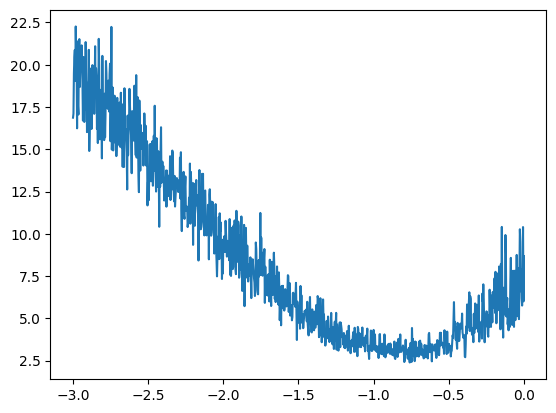

In [107]:
plt.plot(lri, lossi)\ # 10의 -1승인 0.1이 꽤 좋은 lr이였다...

In [118]:
# 전체 데이터셋에 대한 성능 다시
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4511, grad_fn=<NllLossBackward0>)

In [119]:
# 우리가 계속 다뤘던 loss는 사실 train dataset에 대한 loss이다.
# 매개변수를 늘리면 늘릴수록 train dataset에 대한 loss는 줄어들 수 있겠지. 하지만 과적합임 이건.
# 일반적으로 3개의 dataset으로 나눈다. training split, dev/validation split, test split
# 일반적으로 80%, 10%, 10%으로 나눔.
# train dataset: 'parameter' 조절
# validation dataset: 'hyperparameter' 조절
# train dataset: evaluate the performance of the model at the end

test dataset에 대한 loss는 적게 확인해야 함.

테스트 결과를 보고 모델 설계를 바꾸는 순간, 그 데이터는 더 이상 "본 적 없는" 데이터가 아닙니다.

자주 확인하고 코드를 고칠수록, 모델은 점점 테스트 데이터셋의 '특성'에만 잘 들어맞는 '가짜 천재'가 되어갑니다.

결국 실제 세상에 나갔을 때(진짜 새로운 데이터를 만났을 때) 모델이 멍청해지는 현상이 발생합니다.

개발 과정에서는 오직 Dev set만 보고 지지고 볶고 다 하되, Test set은 딱 한 번, 혹은 정말 가끔만 열어봐서 진짜 실력을 확인하라

세 가지 시나리오
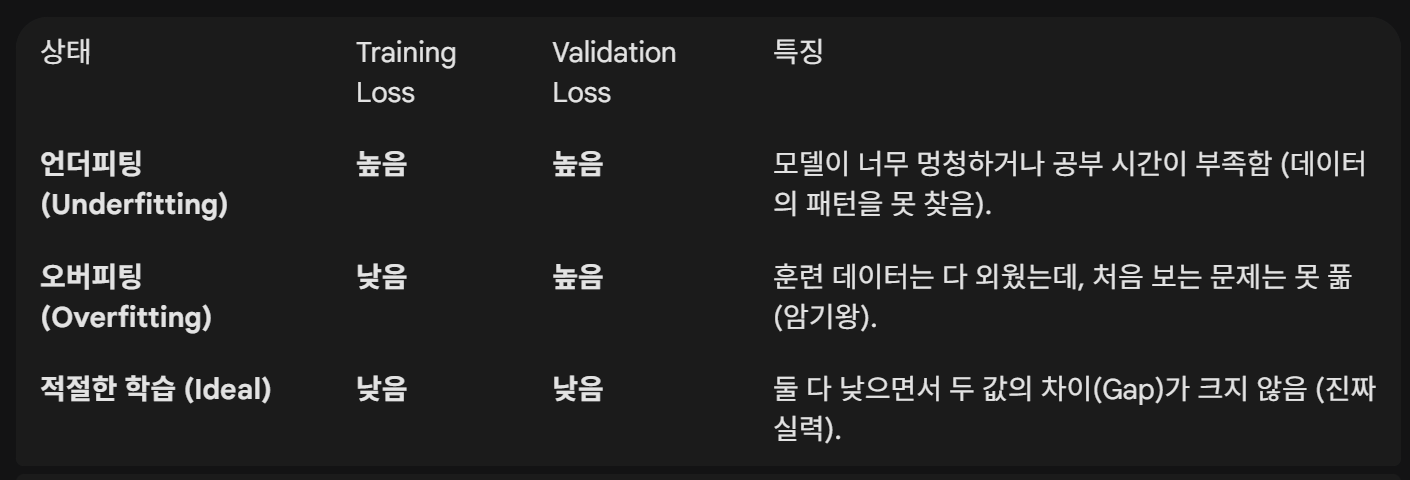

🟢 언더피팅 (Underfitting: "더 공부해야 해!")
현상: 두 손실 값 모두 줄어들 기미가 없거나, 아주 높은 지점에서 평행선을 그립니다.

이유: 신경망의 크기(파라미터 수)가 너무 작아서 데이터에 담긴 복잡한 규칙을 담아낼 그릇이 안 되는 경우입니다.

카파시의 처방: 은닉층의 뉴런 개수를 늘리거나(h의 크기), 임베딩 크기를 키우거나, 문맥 창(block_size)을 더 넓혀보세요.

🔴 오버피팅 (Overfitting: "문제집을 외워버렸어!")
현상: Training Loss는 계속 떨어지는데, 어느 순간부터 Validation Loss가 다시 올라가거나 더 이상 떨어지지 않고 멈춥니다.

이유: 모델이 데이터의 '본질'이 아니라 '노이즈(사소한 특징)'까지 다 외워버린 상태입니다. 훈련 데이터에만 특화된 '고집불통'이 된 거죠.

카파시의 처방: 정규화(Regularization)를 추가하거나, 모델의 크기를 줄이거나, 더 많은 데이터를 가져오세요.

🔵 적절한 학습 (Good Fit: "이게 진짜 실력이지")
현상: 두 그래프가 함께 사이좋게 내려갑니다.

보통 Validation Loss가 Training Loss보다 아주 약간 높은 상태를 유지하며 수렴하는 것이 가장 이상적입니다.

In [120]:
# 강의에서는 매 mini batch 마다 loss를 기록해서 그래프로 보여줬고
# 마지막에 전체 train loss와 validation loss를 비교함

In [ ]:
# 여러가지 하이퍼파라미터들을 바꿔보면서 train loss와 validation loss를 관찰해
# batch 수를 조절할 수도 있어.

강의 후반부에는 2차원에서 임베딩된 것을 직접 보여주기도 함.

1. 왜 아무 코딩도 안 했는데 유유상종이 될까? (The "Invisible Hand")

우리는 "모음끼리 모여라"라는 코드를 짠 적이 없지만, **손실 함수(Loss Function)**라는 강력한 목표가 모델을 그렇게 몰아넣었습니다.

비슷한 역할, 비슷한 그래디언트: 모델의 목표는 다음 글자를 맞히는 것입니다. 그런데 실제 이름 데이터에서 'a'와 'e'는 비슷한 위치에 자주 등장합니다 (예: ka..., ke...).

교체 가능성: 신경망 입장에서는 'a'가 들어왔을 때나 'e'가 들어왔을 때나, 다음에 올 글자의 확률 분포가 비슷하다면 이 두 글자를 비슷하게 취급하는 것이 효율적입니다.

역전파의 마법: 'a'를 넣었을 때 틀려서 가중치를 수정하고, 'e'를 넣었을 때 틀려서 가중치를 수정하다 보면, 결국 두 글자의 임베딩 벡터(C)는 신경망의 다음 층($W_1$)이 동일하게 처리하기 좋은 지점으로 함께 끌려가게 됩니다.

결론: 신경망은 "정답을 더 잘 맞히기 위해" 스스로 데이터를 분류하고 구조화하는 능력을 갖추고 있습니다. 이것이 바로 우리가 딥러닝을 **'특성 학습(Feature Learning)'**이라고 부르는 이유입니다.

2. 차원의 저주 (The Curse of Dimensionality)

"임베딩 차원을 무작정 키우면 더 똑똑해지지 않을까?"라는 생각에 찬물을 끼얹는 개념입니다. 차원이 높아질수록 데이터가 차지하는 공간이 기하급수적으로 넓어지면서 발생하는 문제들을 말합니다.

① 데이터가 너무 외로워짐 (Data Sparsity)

1차원: 10개의 점으로 선 하나를 꽉 채울 수 있습니다.

2차원: 선과 같은 밀도를 유지하려면 $10 \times 10 = 100$개의 점이 필요합니다.

10차원: 같은 밀도를 위해 $10^{10}$ (100억 개)의 데이터가 필요합니다!

공간은 광활해지는데 데이터는 그대로이니, 데이터 사이의 거리가 너무 멀어져서 모델이 "주변에 참고할 데이터가 없네?"라며 길을 잃게 됩니다.

② 모든 것이 멀게 느껴짐 (Distance Meaninglessness)

고차원에서는 모든 데이터 포인트 사이의 거리가 거의 비슷해지는 기현상이 발생합니다. "가깝다"와 "멀다"의 구분이 모호해지니, 모델이 데이터 사이의 관계를 파악하기가 매우 힘들어집니다.

③ 과적합(Overfitting)의 온상

공간이 너무 넓으면 모델이 데이터 사이의 일반적인 규칙을 찾기보다, 각 데이터를 하나하나 외워버리기(Memorization) 훨씬 쉬워집니다. 훈련 데이터는 완벽히 맞히지만, 처음 보는 데이터가 광활한 빈 공간 어딘가에 떨어지면 모델은 대답을 못 하게 됩니다.

# Part 3